<h1>Base Analysis of sparkifydb</h1>
<p>This notebook shows some basic analysis of the newly entered data in sparkifydb. For more information about sparkifydb, please refer to the repository readme.</p>
<p>Please consider, that the data is only simualted (not-real) and only partially available (only a subset of songs and users, only month 2018-11). This of course tightens the potential analysis spectrum and its significance, especially as we only have detailed Song and Artist IDs for one record. So no analysis concerning songs or artists is possible.</p>

<p>First the libraries are imported, the connection is created and the fact (songplays) table is imported as a pandas dataframe joined with the time table</p>

In [1]:
#import libraries
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#create connection
conn = psycopg2.connect("host=127.0.0.1 dbname=sparkifydb user=student password=student")
cur = conn.cursor()

In [36]:
sql = "SELECT s.*, t.hour, t.weekday, u.gender, u.level \
       FROM songplays s LEFT JOIN time t \
       ON t.start_time = s.start_time LEFT JOIN users u\
       ON u.user_id = s.user_id"
user_sql = "SELECT * FROM users"

In [80]:
fact_df = pd.read_sql(sql, conn)
user_df = pd.read_sql(user_sql, conn)
#add state column
fact_df["state"] = [x[-2:] for x in list(fact_df.location.values)]
dropcols = ["song_id", "artist_id", "location", "user_agent", "user_id"]
fact_df.drop(dropcols, axis=1, inplace=True)

In [81]:
fact_df.head(3)

,songplay_id,start_time,level,session_id,hour,weekday,gender,level,state
0,1,2018-11-13 00:40:37.796,free,514,0,1,M,free,PA
1,2,2018-11-13 01:12:29.796,free,510,1,1,F,free,TX
2,3,2018-11-13 03:19:02.796,free,379,3,1,M,free,CA


In [46]:
user_df.head(3)

,user_id,first_name,last_name,gender,level
0,66,Kevin,Arellano,M,free
1,51,Maia,Burke,F,free
2,9,Wyatt,Scott,M,free


<p>Now let's have a look at some basic analysis concerning some time features</p>
<p>Apparently most users listen to their songs in the late afternoon hours. It makes sense, that we see the lowest numbers here in the late night and earyl morning hours.</p>

Text(0,0.5,'No. of Songplays')

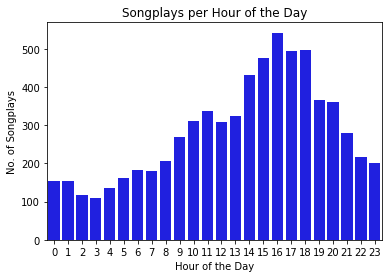

In [48]:
hour_df = fact_df[["hour", "songplay_id"]].groupby("hour").agg("count").reset_index()
sns.barplot(x="hour", y="songplay_id", data=hour_df, color="blue")
plt.title("Songplays per Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("No. of Songplays")

<p>There are obviously a lot less songplays on Fridays and Saturdaysand for some reason Tuesdays and Thursday show slightly higher numbers.</p>

Text(0,0.5,'No. of Songplays')

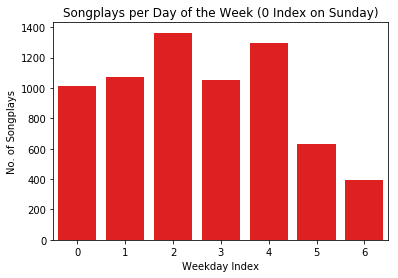

In [49]:
wd_df = fact_df[["weekday", "songplay_id"]].groupby("weekday").agg("count").reset_index()
sns.barplot(x="weekday", y="songplay_id", data=wd_df, color="red")
plt.title("Songplays per Day of the Week (0 Index on Sunday)")
plt.xlabel("Weekday Index")
plt.ylabel("No. of Songplays")

<p>Obviously Sparkify (at least in November 18) was over represented in some states, e.g. California. Of course in a more detailed analysis one has to consider the total population of a state as well.</p>

Text(0.5,1,'Songplays by State')

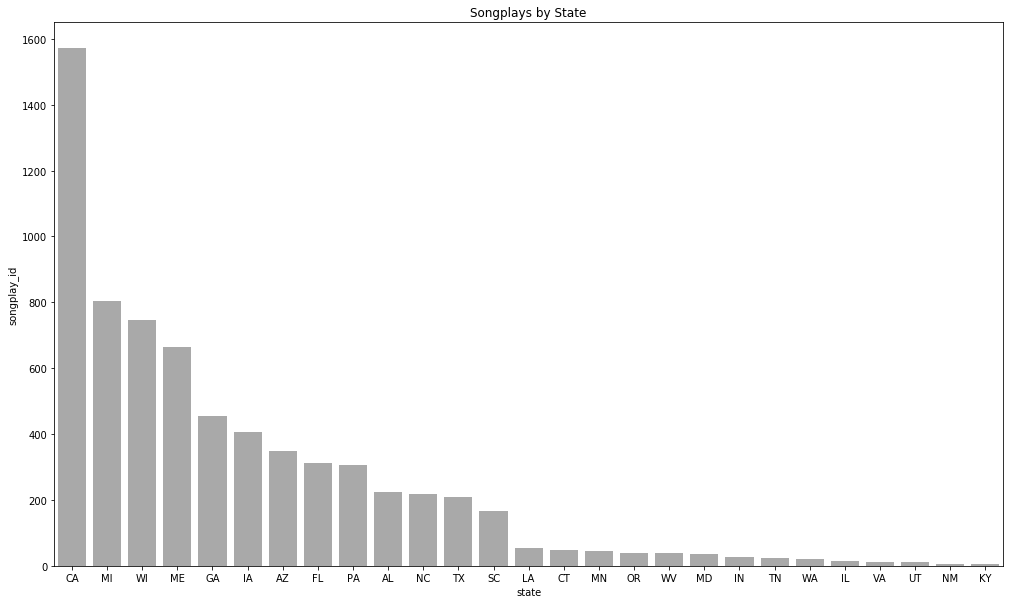

In [58]:
state_df = fact_df[["state", "songplay_id"]].groupby("state").agg("count").reset_index()
plt.figure(figsize=(17, 10))
states_list = sorted(list(state_df["state"].value_counts().index))
sns.barplot(x="state", y="songplay_id", color="darkgrey", 
              data=state_df, order=fact_df.state.value_counts().index)
plt.title("Songplays by State")

<p>Now let's have a look at the availble user structure</p>

<p>In total we have 96 unique users in our dataset, since the user_id column is a primary key in the users table.</p>

In [59]:
user_df.shape

(96, 5)

<p>There are slighly more female users than male, but we have a significantly higher level of free users in our dataset.</p>

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


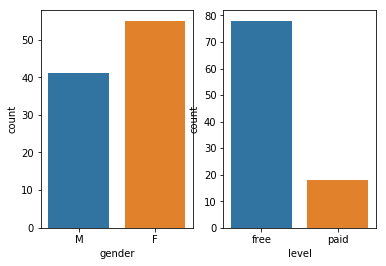

In [38]:
fig, ax = plt.subplots(1, 2)
sns.countplot(x=user_df.gender, ax=ax[0])
sns.countplot(x=user_df.level, ax=ax[1])
fig.show()

<p>There is a slightly higher share for paying listeners in the female users, but nearly no difference in between the genders in listening beahviour over the hours of a day. Although apparetnly there are differences in our dataset between the genders over the days of a week (see last chart below).</p>

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


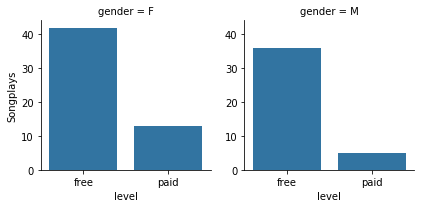

In [75]:
gender_df = user_df[["gender", "level", "user_id"]].groupby(["gender", "level"]).agg("count").reset_index()
gender_df.rename({"user_id": "Songplays"}, axis=1, inplace=True)
g = sns.FacetGrid(data=gender_df, col="gender")
g.map(sns.barplot, "level", "Songplays")

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


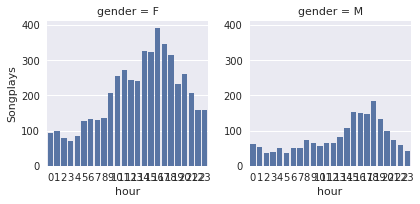

In [92]:
hourgender_df = fact_df[["gender", "hour", "songplay_id"]].groupby(["gender", "hour"]).agg("count").reset_index()
hourgender_df.rename({"songplay_id": "Songplays"}, axis=1, inplace=True)

g = sns.FacetGrid(data=hourgender_df, col="gender")
g.map(sns.barplot, "hour", "Songplays")

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


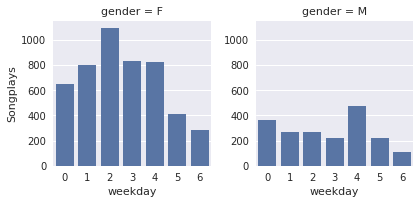

In [93]:
wdgender_df = fact_df[["gender", "weekday", "songplay_id"]].groupby(["gender", "weekday"]).agg("count").reset_index()
wdgender_df.rename({"songplay_id": "Songplays"}, axis=1, inplace=True)
g = sns.FacetGrid(data=wdgender_df, col="gender")
g.map(sns.barplot, "weekday", "Songplays")

In [94]:
#close connecion
conn.close()